Creating the kinetic data curve fitting script

# Importing the data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import pandas as pd


#Import Data + Clean Data
def importCleanData(file_name, sheet, columns):
    data = pd.read_excel(file_name, sheet_name = sheet)
    cleanData = data.loc[:, columns].dropna()
    return cleanData

# Change the working directory 
print(os.getcwd()) # Prints the current working directory
# directories 
justin = 'C:/Users/dhlpablo_m2/Desktop/Git/Data_extraction_kinetic_signaling_data/data/train_data/vegf_testdata'
Lionel = 'C:/Users/Imoukhuede lab/OneDrive - UW/Desktop/GitHub/Data_extraction_kinetic_signaling_data/data/train_data/vegf_testdata'
# Provide the new path here
os.chdir(Lionel) 
# Prints the new working directory
print(os.getcwd())

# Import Data
testFile1 = pd.read_excel("VEGFA165_NRP1_0.5-8nM_Lu2023.xlsx", sheet_name = "sheet1")
testFile105 = importCleanData("VEGFA165_NRP1_0.5-8nM_Lu2023.xlsx", "sheet1", ["Time 0.5nM", "RU 0.5nM"])


C:\Users\Imoukhuede lab\OneDrive - UW\Desktop\GitHub\Data_extraction_kinetic_signaling_data\data\train_data\vegf_testdata
C:\Users\Imoukhuede lab\OneDrive - UW\Desktop\GitHub\Data_extraction_kinetic_signaling_data\data\train_data\vegf_testdata


# Defining the functions

In [86]:
# Fitting equation to Find the kon value

def baseline_steadystate_response(y_initial, y_final, t, kon):
    """
    Function to find the kon value from the data. 
    Assuming we know the baseline and the steady state response, we can find the kon value.
    The equation is y(t) = y_final * (1 - exp(-kon * t)) + y_intial

    Parameters
    ----------
    data : pandas dataframe
        Dataframe containing the time and response values
    y_intial : float
        The baseline value of the response
    y_final : float
        The steady state value of the response
    t : float
        The time value

    Returns
    -------
    function
        The function that can be used to calculate the response
    """
    return y_final * (1 - np.exp(-kon * t)) + y_initial

In [87]:
def response_to_zero(C, y_initial, t, kon, koff):
    """
    Function to find the kon and koff values from the data
    Assuming we know that the response goes to zero

    Parameters
    ----------
    data : pandas dataframe
        Dataframe containing the time and response values
    C : float
        The initial rate of signaling
    y_initial : float
        The baseline value of the response
    t : float
        The time value
    
    Returns
    -------
    function
        The function that can be used to calculate the response

    """
    return (C / (kon - koff)) * (np.exp(-koff * t) - np.exp(-kon * t)) +y_initial


In [88]:

def response_to_steady_state(y_initial, y_final, t, D, kon, koff):
    """
    Function to find the kon and koff values from the data
    Assuming we know the steady state response

    Parameters
    ----------
    data : pandas dataframe
        Dataframe containing thetime and response values
    y_initial : float
        The initial rate of signaling
    y_final : float
        The final rate of signaling
    t : float
        The time value
    
    Returns
    -------
    function
        The function that can be used to calculate the response

    """
    return y_final * ((1 - D * np.exp(-kon * t)) + (D - 1) * np.exp(-koff * t)) + y_initial

In [89]:
# Typical association
def typical_association(y_final, t, C, kon, koff):
    """
    Function to find the kon and koff values from the data
    Assuming it is a typical association function

    Parameters
    ----------
    data : pandas dataframe
        Dataframe containing thetime and response values
    y_final : float
        The final rate of signaling
    t : float
        The time value
    C : float
        The concentration of the substance
    
    Returns
    -------
    function
        The function that can be used to calculate the response

    """
    kd = koff/kon
    return (y_final * C) / (kd + C) * (1 - 1 / np.exp(kon * C + koff) * t)

In [90]:
# Typical dissociation
def typical_dissociation(y_initial, t, koff):
    """
    Function to find the koff values from the data
    Assuming it is a typical dissociation function

    Parameters
    ----------
    data : pandas dataframe
        Dataframe containing thetime and response values
    y_initial : float
        The initial rate of signaling
    t : float
        The time value
    
    Returns
    -------
    function
        The function that can be used to calculate the response

    """
    return y_initial * np.exp(-koff * t)

## Whole function test

In [91]:
# Fitting the data to the equation
def fit_data(data, time, resposne, assumption = "response to steady state", y_final = None, y_initial = None, C = None, D = None, kon=None, koff=None):
    """
    Function to fit the data to the function

    Parameters
    ----------
    data : pandas dataframe
        Dataframe containing the time and response values
    function : function
        The function that will be used to fit the data

    Returns
    -------
    param_k
        The parameters of the function
    pcov_k  
        The covariance of the parameters
    """

    if assumption == "baseline+steadystate":
        def baseline_steadystate_response(y_initial, y_final, t, kon):
            """
            Function to find the kon value from the data. 
            Assuming we know the baseline and the steady state response, we can find the kon value.
            The equation is y(t) = y_final * (1 - exp(-kon * t)) + y_intial

            Parameters
            ----------
            data : pandas dataframe
                Dataframe containing the time and response values
            y_intial : float
                The baseline value of the response
            y_final : float
                The steady state value of the response
            t : float
                The time value

            Returns
            -------
            function
                The function that can be used to calculate the response
            """
            return y_final * (1 - np.exp(-kon * t)) + y_initial
        function = baseline_steadystate_response

    elif assumption == "response to zero":
        def response_to_zero(C, y_initial, t, kon, koff):
            """
            Function to find the kon and koff values from the data
            Assuming we know that the response goes to zero

            Parameters
            ----------
            data : pandas dataframe
                Dataframe containing the time and response values
            C : float
                The initial rate of signaling
            y_initial : float
                The baseline value of the response
            t : float
                The time value
            
            Returns
            -------
            function
                The function that can be used to calculate the response

            """
            return (C / (kon - koff)) * (np.exp(-koff * t) - np.exp(-kon * t)) +y_initial
        
        function = response_to_zero

    elif assumption == "response to steady state":
        def response_to_steady_state(y_initial, y_final, t, D, kon, koff):
            """
            Function to find the kon and koff values from the data
            Assuming we know the steady state response

            Parameters
            ----------
            data : pandas dataframe
                Dataframe containing thetime and response values
            y_initial : float
                The initial rate of signaling
            y_final : float
                The final rate of signaling
            t : float
                The time value
            
            Returns
            -------
            function
                The function that can be used to calculate the response

            """
            return y_final * ((1 - D * np.exp(-kon * t)) + (D - 1) * np.exp(-koff * t)) + y_initial
        
        function = response_to_steady_state

    param_k, pcov_k = curve_fit(function, time, resposne)

    return param_k, pcov_k

# Test the fitting functions

In [92]:
testFile105

,Time 0.5nM,RU 0.5nM
4,1.366,-0.209
5,3.924,0.552
6,12.878,1.060
7,23.750,1.377
8,37.180,1.758
9,55.727,1.885
10,71.076,1.948
11,90.901,1.948
12,105.610,1.948
13,117.762,1.885


In [93]:
param_k

array([-167.51738051, -134.93802665,    1.        , -134.93802665,
          1.        ])

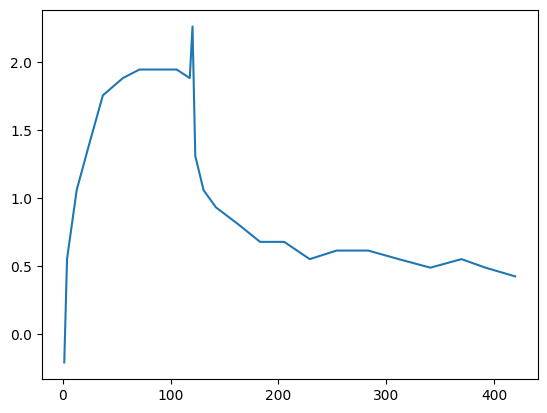

c:\Users\Imoukhuede lab\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


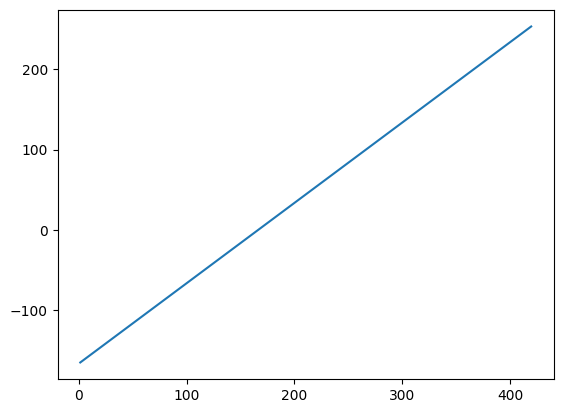

In [115]:
# test 0
testFile105 = importCleanData("VEGFA165_NRP1_0.5-8nM_Lu2023.xlsx", "sheet1", ["Time 0.5nM", "RU 0.5nM"])
# remove the first 4 rows
testFile105 = testFile105.iloc[4:]
testFile105
# plot the data
plt.plot(testFile105["Time 0.5nM"], testFile105["RU 0.5nM"])
plt.show ()

# Initial guess for the parameters
y_initial = testFile105.iloc[0, 1]
y_final = testFile105["RU 0.5nM"].iloc[-1]  # Extract the single value
initial_guess = [y_initial, y_final, 6e1, 0.5, 1]

# data
t_data = testFile105["Time 0.5nM"]
response_data = testFile105["RU 0.5nM"]

param_k, pcov_k = curve_fit(response_to_steady_state, t_data, response_data, p0=initial_guess)
# plot the fitted data 
# created fitted response data
fitted_response= response_to_steady_state(testFile105["Time 0.5nM"], *param_k)
plt.plot(testFile105["Time 0.5nM"], fitted_response, label='Fitted Data')
plt.show ()

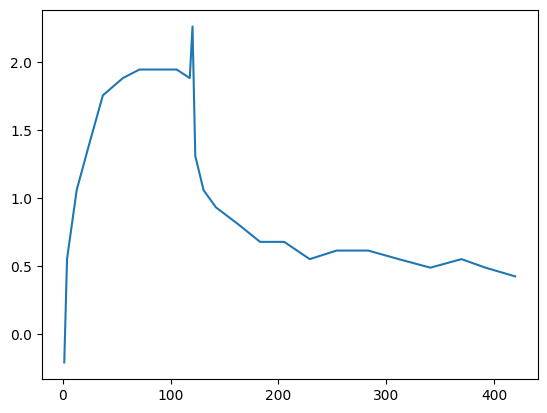

C:\Users\Imoukhuede lab\AppData\Local\Temp\ipykernel_3312\666557803.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  param_k, pcov_k = fit_data(testFile105,testFile105["Time 0.5nM"], testFile105["RU 0.5nM"], assumption = "response to steady state", y_final = testFile105["RU 0.5nM"][-1:], y_initial = testFile105.iloc[0, 1])
c:\Users\Imoukhuede lab\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


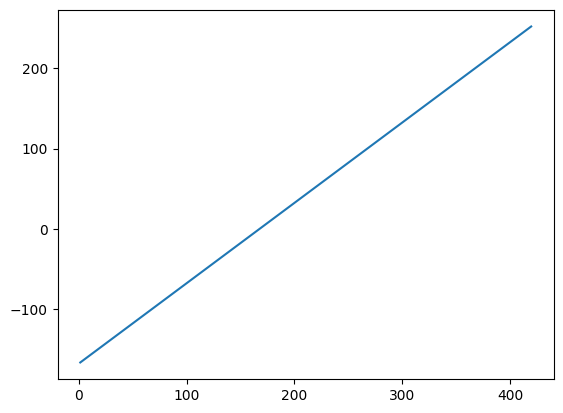

array([-167.51738051, -134.93802665,    1.        , -134.93802665,
          1.        ])

In [105]:
# Test 1
#testFile1
testFile105 = importCleanData("VEGFA165_NRP1_0.5-8nM_Lu2023.xlsx", "sheet1", ["Time 0.5nM", "RU 0.5nM"])
# remove the first 4 rows
testFile105 = testFile105.iloc[4:]
testFile105
# plot the data
plt.plot(testFile105["Time 0.5nM"], testFile105["RU 0.5nM"])
plt.show ()
# fit the data
param_k, pcov_k = fit_data(testFile105,testFile105["Time 0.5nM"], testFile105["RU 0.5nM"], assumption = "response to steady state", y_final = testFile105["RU 0.5nM"][-1:], y_initial = testFile105.iloc[0, 1])
# plot the fitted data 
# created fitted response data
fitted_response= response_to_steady_state(testFile105["Time 0.5nM"], *param_k)
plt.plot(testFile105["Time 0.5nM"], fitted_response, label='Fitted Data')
plt.show ()

# Plotting the fit to a pot of the data

In [96]:
#Data Reporting

def plot_data(fitted_response, time_pt, response_data, function, fitted_param, label):
    """
    This function plots the data and the fitted data on the same graph against time

    Parameters
    ----------
    fitted_response : pandas dataframe
        The dataframe containing the time and response values
    time_pt : string
        The column name of the time values
    response_data : string
        The column name of the response values
    function : function
        The function that was used to fit the data
    fitted_param : list
        The parameters of the function
    label : string
        The label of the data

    Returns
    -------
    None
    """
    plt.scatter(fitted_response[time_pt], fitted_response[response_data], label=f'{label} Data')
    plt.plot(fitted_response[time_pt], function(fitted_response,response_data)(fitted_response[time_pt], *fitted_param), 'r-', label=f'{label} Fit')

    plt.figure()
    plt.title()
    plt.show()

def data_stats():
    np.mean()
    np.ptp()
    np.std()